In [1]:
with open("import_modules.py") as f:
    exec(f.read())

from graph import GraphViz
import pydot

All imported
All imported


In [2]:
from sklearn.ensemble import RandomForestClassifier
from joblib import load
from sentence_transformers import SentenceTransformer
import numpy as np
from nltk import word_tokenize, pos_tag

main_pos_tags = {'Noun': ['NN', 'NNS', 'NNP', 'NNPS'],
                 'Pronoun': ['PRP', 'PRP$'],
                 'Adjective': ['JJ', 'JJR', 'JJS'],
                 'Verb': ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'],
                 'Adverb': ['RB', 'RBR', 'RBS'],
                 'Determiner': ['DT', 'PDT', 'WDT'],
                 'Numeral': ['CD']
                }

def count_main_pos_tags(sentence):
    pos_tags = nltk.pos_tag(nltk.word_tokenize(sentence))
    tag_counts = {tag_group: 0 for tag_group in main_pos_tags}
    for word, tag in pos_tags:
        for tag_group, tags in main_pos_tags.items():
            if tag in tags:
                tag_counts[tag_group] += 1
    return tag_counts

def for_class(df,x):
    model = SentenceTransformer('all-MiniLM-L6-v2')
    db=df[[x]]
    db["length"]=db[x].apply(lambda x: len(word_tokenize(x)))
    db['main_pos_counts'] = db[x].apply(count_main_pos_tags)
    db = pd.concat([db.drop('main_pos_counts', axis=1), db['main_pos_counts'].apply(pd.Series)], axis=1)
    db["rel_nouns"]=db["Noun"]/db["length"]
    db["rel_pronouns"]=db["Pronoun"]/db["length"]
    db["rel_adjectives"]=db["Adjective"]/db["length"]
    db["rel_verbs"]=db["Verb"]/db["length"]
    db["rel_adverbs"]=db["Adverb"]/db["length"]
    db["rel_determiners"]=db["Determiner"]/db["length"]
    db["rel_numerals"]=db["Numeral"]/db["length"]
    db.loc[:, x] = db.loc[:, x].apply(lambda x: model.encode(x))
    embeddings_arg1 = np.vstack(db.loc[:, x].values)
    len_arg1 = np.expand_dims(db.loc[:, 'length'].values, axis=1)
    nouns=np.expand_dims(db.loc[:, 'Noun'].values, axis=1)
    pronouns=np.expand_dims(db.loc[:, 'Pronoun'].values, axis=1)
    adjectives=np.expand_dims(db.loc[:, 'Adjective'].values, axis=1)
    verbs=np.expand_dims(db.loc[:, 'Verb'].values, axis=1)
    rel_nouns=np.expand_dims(db.loc[:, 'rel_nouns'].values, axis=1)
    rel_pronouns=np.expand_dims(db.loc[:, 'rel_pronouns'].values, axis=1)
    rel_adjectives=np.expand_dims(db.loc[:, 'rel_adjectives'].values, axis=1)
    rel_verbs=np.expand_dims(db.loc[:, 'rel_verbs'].values, axis=1)
    rel_adverbs=np.expand_dims(db.loc[:, 'rel_adverbs'].values, axis=1)
    rel_determiners=np.expand_dims(db.loc[:, 'rel_determiners'].values, axis=1)
    rel_numerals=np.expand_dims(db.loc[:, 'rel_numerals'].values, axis=1)
    db= np.hstack([embeddings_arg1, len_arg1, nouns, pronouns, adjectives, verbs, rel_nouns, rel_pronouns, rel_adjectives, rel_verbs, rel_adverbs, rel_determiners, rel_numerals])
    
    return db



The **_'merge_concepts'_** function combines the subjects, including the paragraph title, using cosine_similarity. For word embedding, the TfidfVectorizer is used. Following the computation of the similarity matrix, subject clusters are formed using a similarity threshold of 0.4. The function then merges overlapping clusters to ensure that no concept is assigned to more than one cluster and generates a dictionary in which each subject is mapped to the simplest subject within its cluster in terms of length. If the cluster contains the title, however, each subject is mapped to it (since the title node cannot be removed). The subjects of the relations, which are in the 'arg1' column of the data frame, are then modified with the dictionary that was constructed.

In [3]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer=TfidfVectorizer(ngram_range=(1,2))

def merge_concepts(df, title):
    #compute similarity matrix between subjects
    nodes = list(df['arg1'].unique()) + [title]
    similarity_matrix = cosine_similarity(vectorizer.fit_transform(nodes))
    
    #create clusters of similar subjects
    set_list = []
    for i in range(len(nodes)):
        s = set([nodes[j] for j in range(len(nodes)) if i != j if similarity_matrix[i][j] > 0.4])
        s.add(nodes[i])
        set_list.append(s)
    for i in range(len(set_list)):
        for j in range(i+1, len(set_list)):
            if set_list[i] & set_list[j]:
                set_list[i] = set_list[i] | set_list[j]
                set_list[j] = set()
    set_list = [s for s in set_list if s]
    
    #create dictionary to substitute subjects with the simpliest one in the cluster
    d = {}
    for s in set_list:
        if title in s:
            simplest_concept = title
        else:
            simplest_concept = min(s, key=lambda x: len(x))
        for concept in s:
            d[concept] = simplest_concept
            
    #substitute subjects in dataframe
    df.arg1= df.arg1.map(d)
    return df

When an 'and' conjunction appears in a phrase between two nouns, the Stanford OpenIE server extracts separate relations. For example, 

Original Phrase: The Cold War was between the US and the Soviet Union 

Relations Extracted: (The Cold War,  was,  between the US),
                     (The Cold War,  was,  between the Soviet Union)
                     
Original Phrase: France and Britain are still referred to as "historic rivals"

Relations Extracted: (France, are still referred to, as "historic rivals"),
                     (Britain, are still referred to, as "historic rivals")

The **_'concat_concepts'_** function groups the dataframe by subject and relation before using **_'concat_objects'_**. This function takes the grouped relations and connects the concepts to form the original phrase. Similarly, when two subjects are linked by 'and', the server divides them. The function **_'concat_subjects'_** accepts a dataframe that has been grouped by relation and object and connects the subjects with 'and'.

In [4]:
#Concatenate objects with commas and 'and' where there is the same subject and relation
def concat_objects(relation):
    object_list = relation['arg2'].tolist()
    max_conf = np.max(relation['confidence'])
    common = ''
    first = object_list[0].split(' ')
    for i in range(len(first)):
        if all(obj.startswith(common) for obj in object_list):
            if common == '':
                common += first[i] 
            elif i < len(first) - 1:
                common += ' ' + first[i]
        else:
            common = ' '.join(common.split(' ')[:-1])
            break
    common = common.rstrip()  
    if common == '':
        return max_conf, ', '.join(object_list)
    objects = [obj[len(common):].lstrip() for obj in object_list]
    if all(obj == '' for obj in objects):
        return max_conf, (common).rstrip()
    if len(objects) == 1:
        return max_conf, (common + ' ' + objects[0]).rstrip()
    return max_conf, (common + ' ' + ', '.join(objects[:-1]) + ' and ' + objects[-1]).rstrip()

#Concatenate subjects with 'and' where there is the same object and relation
def concat_subjects(relation):
    subject_list = relation['arg1'].tolist()
    max_conf = np.max(relation['confidence'])
    return max_conf, (' and '.join(subject_list)).rstrip()

def concat_concepts(df):
    result = df.groupby(['arg1', 'rel']).apply(concat_objects).reset_index()
    result['confidence'], result['arg2'] = zip(*result[0])
    result = result.drop(columns = 0).sort_values(by='confidence', ascending=False).reset_index(drop=True)
    result = result.groupby(['arg2', 'rel']).apply(concat_subjects).reset_index()
    result['confidence'], result['arg1'] = zip(*result[0])
    result = result.drop(columns = 0).sort_values(by='confidence', ascending=False).reset_index(drop=True)
    result = result[['confidence', 'arg1', 'rel', 'arg2']]
    return result

The __*'filter_rows'*__ method first removes duplicate phrases, and then,  if one phrase is a substring of another, it keeps only the longest one (since it is thought to be more informative and less likely to be a truncated sentence). 
The __*'remove_similar_phrases'*__ function removes the shortest one among those that are similar, using cosine_similarity as the metric and TF-IDF for the word embedding. The similarity threshold used is 0.3.

In [5]:
#Remove duplicates, subphrases, and similar phrases
def filter_rows(df):
    seen = set()
    for i, row in df.iterrows():
        phrase = row['arg1'] + ' ' + row['rel'] + ' ' + row['arg2']
        if phrase in seen:
            df = df.drop(i)
        else:
            seen.add(phrase)
    df = df.reset_index(drop=True)
    for l1 in list(seen):
        for l2 in list(seen):
            if l1 != l2 and l1 in l2:
                try:
                    seen.remove(l1)
                except KeyError:
                    continue
    df = df[(df['arg1'] + ' ' + df['rel'] + ' ' + df['arg2']).isin(seen)].reset_index(drop=True)
    return df

def remove_similar_phrases(df):
    rem_ind = set()
    df['phrase'] = df['arg1'] + ' ' + df['rel'] + ' ' + df['arg2']
    #print(df['phrase'])
    sim = cosine_similarity(vectorizer.fit_transform(df['phrase']))
    for i in range(len(sim)):
        for j in range(i+1, len(sim)):
            if sim[i][j] > 0.3:
                #print(df['phrase'].unique(), df['phrase'][j])
                if len((df['phrase'][i]).split(' ')) > len((df['phrase'][j]).split(' ')):
                    rem_ind.add(j)
                else:
                    rem_ind.add(i)
    return df.drop(rem_ind).reset_index(drop = True).drop('phrase', axis = 1)

In [6]:
list_prep = ['in', 'on', 'at', 'of', 'by', 'with',
             'about', 'to', 'from', 'into', 'through', 
             'over', 'under', 'above', 'below', 'behind',
             'beside', 'between', 'among', 'during', 'until', 
             'without', 'within', 'upon', 'against']

The __*'extract_keywords_TR'*__ and __*'extract_keywords_RAKE'*__ routines detect keywords using the summa and multi_rake libraries, respectively. 
Two dictionaries are produced, with each detected keyword mapped to its importance score.
The __*'compute_keywords_score'*__ function computes the number of keywords found in each phrase as well as the total score supplied by the sum of the scores of the keywords contained. 
For each sentence, the __*'assign_keywords_score'*__ computes the TextRank and RAKE counts and scores. 

In [7]:
from summa import keywords
from multi_rake import Rake
rake = Rake()

def extract_keywords_TR(df):
    TR_keywords = {}
    for j in range(df.shape[0]):
        extract_keywords = keywords.keywords(df.loc[j]['text'], scores=True)
        d = {}
        for k in extract_keywords:
            d[k[0]] = k[1]
        TR_keywords[df.loc[j]['title']] = d
    return TR_keywords

def extract_keywords_RAKE(df):
    RAKE_keywords = {}
    for j in range(df.shape[0]):
        extract_keywords = rake.apply(df.loc[j]['text'])[:30]
        d = {}
        for k in extract_keywords:
            d[k[0]] = k[1]
        RAKE_keywords[df.loc[j]['title']] = d
    return RAKE_keywords

def compute_keywords_score(s, keywords_dic):
    count, sum_scores = 0, 0
    for k, score in keywords_dic.items():
        if k in s.lower():
            count += 1
            sum_scores += score
    return count, sum_scores

In [8]:
def compute_TR_RAKE(df):
    TR_keywords = extract_keywords_TR(df)
    RAKE_keywords = extract_keywords_RAKE(df)
    return TR_keywords, RAKE_keywords

def assign_keywords_score(df_tot, df_rel, title):
    TR_keywords, RAKE_keywords = compute_TR_RAKE(df_tot)
    df_rel['phrase'] = df_rel['arg1'] + ' ' + df_rel['rel'] + ' ' + df_rel['arg2']
    result_TR = df_rel['phrase'].apply(compute_keywords_score, args = (TR_keywords[title],))
    df_rel['TR_count'], df_rel['TR_score'] = zip(*result_TR)
    result_RAKE = df_rel['phrase'].apply(compute_keywords_score, args = (RAKE_keywords[title],))
    df_rel['RAKE_count'], df_rel['RAKE_score'] = zip(*result_RAKE)
    return df_rel

The __*'relation_preselection'*__ function removes some of the relations based on some features that were detected in the incorrect phrases.  

- The __*'contains_noun'*__ filter excludes phrases with a subject that do not contain a noun. 

- The __*'just_pronouns'*__ filter excludes phrases with an object of only two words and consisting of only pronouns.

- The __*'infinitive_rel'*__ function removes phrases where the connection is in the infinitive form. 

- The __*'not_a_verb'*__ filter removes phrases where the relation lacks a verb.

- The __*'end_in_preposition'*__ function removes phrases in which the concepts (i.e., arg1 and arg2) end in a preposition. 

In [9]:
noun_tags = ['NN', 'NNS', 'NNP', 'NNPS']
pron_tags = ['PRP', 'PRP$']
verb_tags = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']

def relation_preselection(rel_df):
    rel_df = rel_df[rel_df['arg1'].apply(contains_noun)].reset_index(drop = True) #& rel_df['arg2'].apply(contains_noun_)
    rel_df = rel_df[rel_df['arg2'].apply(just_pronouns_)].reset_index(drop = True) 
    rel_df = rel_df[rel_df['rel'].apply(infinitive_rel)].reset_index(drop = True) 
    rel_df = rel_df[rel_df['rel'].apply(not_a_verb)].reset_index(drop = True)
    rel_df = rel_df[rel_df['arg1'].apply(end_in_preposition)].reset_index(drop = True) 
    rel_df = rel_df[rel_df['arg2'].apply(end_in_preposition)].reset_index(drop = True) 
    rel_df.arg1 = rel_df.arg1.apply(lower_casing)
    rel_df.arg2 = rel_df.arg2.apply(lower_casing)
    rel_df.rel = rel_df.rel.apply(lambda x: x.lower())
    return rel_df

#checks if the subject contains at least a noun
def contains_noun(arg):
    l = pd.Series(nltk.pos_tag(word_tokenize(arg)))
    for n in noun_tags:
        if n in list(l.apply(lambda x: x[1])):
            return True
    return False

#checks if the object consists of just one or two pronouns
def just_pronouns_(arg):
    l = list(pd.Series(nltk.pos_tag(word_tokenize(arg))).apply(lambda x: x[1]))
    if len(l) <= 2 and (pron_tags[0] in l or pron_tags[1] in l):
        return False
    return not all([p in pron_tags for p in l])

#checks if there the relation contains only a verb in 'to'
def infinitive_rel(rel):
    l = pd.Series(nltk.pos_tag(word_tokenize(rel)))
    return not ('TO' in list(l.apply(lambda x: x[1])) and len(l) <= 2)

#checks if the relation does not consist of a verb
def not_a_verb(rel):
    l = list(pd.Series(nltk.pos_tag(word_tokenize(rel))).apply(lambda x: x[1]))
    for v in verb_tags:
        if v in l:
            return True
    return False

def lower_casing(arg):
    l = list(pd.Series(nltk.pos_tag(word_tokenize(arg))).apply(lambda x: x[1]))
    if l[0] not in noun_tags and l[0] != 'CD': 
        return ' '.join([arg.split(' ')[0].lower()] + arg.split(' ')[1:])
    return arg

#checks if a concept ends with a preposition (i.e., is truncated)
def end_in_preposition(arg):
    pattern = r'\b\w+(?:\s+\w+)*\s+(?:in|on|at|for|of|by|with|about|to|from|into|through|over|under|above|below|behind|beside|between|among|during|until|without|within|upon|against)\b[.?!"\']?$'
    return not re.search(pattern, arg)


The pipeline for creating conceptual maps consists of applying the functions described above to a dataset of relations. Given the collection of paragraphs to be evaluated, the *resolve_coreferences* notebook is used to replace pronouns with proper nouns, and the *extract_rel* notebook is used to extract the data frame of relations for each paragraph via the OpenIE server. The eval_extract.pickle file contains a dictionary that associates the related data frame of selected relations with each paragraph title. After applying all of the functions described above, the dataset is cut down on the median of the confidence level provided by OpenIE, which measures the model's 'confidence' that the relation extracted is correct.
The trained classifier model is then used to choose the remaining relations. Furthermore, relations with a predicate longer than 6 words and an object of only one word are deleted. Finally, relations that do not contain any keywords (as determined by TextRank or RAKE) are removed. When necessary, the concept map is visualized and saved. 
The procedure is here executed on the set of paragraphs utilized for evaluation and comparison with the baseline and handmade maps.

In [10]:
model = load('model_file.joblib')
def cmap_pipeline(df, df_text, title, min_conf_level, index, save_map = True):
    df = relation_preselection(df)
    #print('relation_preselection')
    df = filter_rows(df)
    df = merge_concepts(df, title)
    #print('merge concepts')
    df = concat_concepts(df)
    df = remove_similar_phrases(df)
    #print('remove similar phrases')
    df = df[df['confidence'] >= df["confidence"].quantile(min_conf_level)].reset_index(drop = True)
    input=for_class(df,"arg1")
    res=model.predict(input)
    df = df.loc[res==1]
    #print('assign score')
    df = assign_keywords_score(df_text, df, title)
    df = df[df['arg2'].apply(lambda x: len(x.split(' ')) > 1)].reset_index(drop = True)
    df = df[df['rel'].apply(lambda x: len(x.split(' ')) < 6)].reset_index(drop = True)
    df = df[(df['TR_score'] != 0)|(df['RAKE_score'] != 0)].reset_index(drop = True)
    if save_map:
        G = GraphViz(df, title)
        G.graph.write_png(f'example_graph_{index}.png')
    else:
        return df

In [11]:
eval_sample = pd.read_csv('../data/new_sample_solved.csv')

In [12]:
with open('eval_extract.pickle', 'rb') as f:
    eval_sample_extractions = pickle.load(f)

In [13]:
len_sentences = []
len_rel = []
len_arg1 = []
len_arg2 = []

In [14]:
for i,title in enumerate(eval_sample_extractions):
    df = eval_sample_extractions[title]
    df['sentence_len'] = df['sentence'].apply(lambda x: len(nltk.word_tokenize(x)))
    df['arg1_len'] = df['arg1'].apply(lambda x: len(nltk.word_tokenize(x)))
    df['arg2_len'] = df['arg2'].apply(lambda x: len(nltk.word_tokenize(x)))
    df['rel_len'] = df['rel'].apply(lambda x: len(nltk.word_tokenize(x)))
    len_sentences.append(df['sentence_len'].mean())
    len_rel.append(df['rel_len'].mean())
    len_arg1.append(df['arg1_len'].mean())
    len_arg2.append(df['arg2_len'].mean())

The graph below depicts the difference in the mean number of words in the full sentence, arg1, rel, and arg2 among the paragraphs chosen for the evaluation.  Subjects and relations have shorter mean lengths than arg2, with the arg2 distribution being more or less uniform.  The mean sentence length distribution is right-skewed, with a peak at roughly 30 words. 

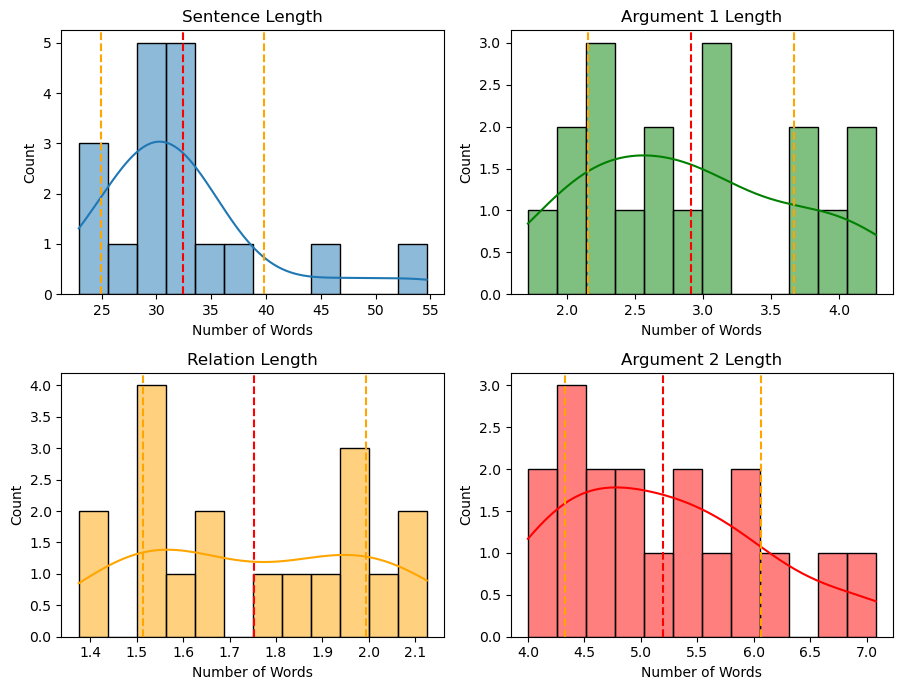

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(2, 2, figsize=(9, 7))

sns.histplot(len_sentences, kde=True, ax = axs[0, 0], alpha = 0.5, bins = 12)
axs[0, 0].set_title('Sentence Length')
axs[0, 0].axvline((np.array(len_sentences)).mean(), color='r', linestyle='--')
axs[0, 0].axvline((np.array(len_sentences)).mean() + (np.array(len_sentences)).std(), color='orange', linestyle='--')
axs[0, 0].axvline((np.array(len_sentences)).mean() - (np.array(len_sentences)).std(), color='orange', linestyle='--')
sns.histplot(len_arg1, kde=True, ax = axs[0,1], color = 'green', alpha = 0.5, bins = 12)
axs[0, 1].set_title('Argument 1 Length')
axs[0, 1].axvline((np.array(len_arg1)).mean(), color='r', linestyle='--')
axs[0, 1].axvline((np.array(len_arg1)).mean() + (np.array(len_arg1)).std(), color='orange', linestyle='--')
axs[0, 1].axvline((np.array(len_arg1)).mean() - (np.array(len_arg1)).std(), color='orange', linestyle='--')
sns.histplot(len_rel, kde=True, ax = axs[1,0], color = 'orange', alpha = 0.5, bins = 12)
axs[1, 0].set_title('Relation Length')
axs[1, 0].axvline((np.array(len_rel)).mean(), color='r', linestyle='--')
axs[1, 0].axvline((np.array(len_rel)).mean() + (np.array(len_rel)).std(), color='orange', linestyle='--')
axs[1, 0].axvline((np.array(len_rel)).mean() - (np.array(len_rel)).std(), color='orange', linestyle='--')
sns.histplot(len_arg2, kde=True, ax = axs[1,1], color = 'r', alpha = 0.5, bins = 12)
axs[1, 1].set_title('Argument 2 Length')
axs[1, 1].axvline((np.array(len_arg2)).mean(), color='r', linestyle='--')
axs[1, 1].axvline((np.array(len_arg2)).mean() + (np.array(len_arg2)).std(), color='orange', linestyle='--')
axs[1, 1].axvline((np.array(len_arg2)).mean() - (np.array(len_arg2)).std(), color='orange', linestyle='--')

for ax in axs.flat:
    ax.set(xlabel = 'Number of Words', ylabel='Count')

fig.tight_layout()

In [16]:
for i, key in enumerate(eval_sample_extractions.keys()):
    cmap_pipeline(eval_sample_extractions[key], eval_sample, key, 0.5, i)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

The __*combine_relations*__ function is used to generate text summaries by merging the map's set of propositions.

In [17]:
def combine_relations(df):
    df['phrase'] = df['arg1'] + ' ' + df['rel'] + ' ' + df['arg2']
    df['phrase'] = df['phrase'].apply(lambda x: ' '.join([x.split(' ')[0].capitalize()] + x.split(' ')[1:]))
    return '. '.join([p for p in df['phrase']]) + '.'

In [18]:
#With save_map == False, the cmap_pipeline returns the data frame of the selected relations 
parag = []
for i, key in enumerate(eval_sample_extractions.keys()):
    df_rel = cmap_pipeline(eval_sample_extractions[key], eval_sample, key, 0.5, i, False)
    parag.append([key, combine_relations(df_rel)])

In [19]:
model_sum = pd.DataFrame(parag, columns = ['title', 'Model_Summary'])